# problem Statement

#### We are required to model the demand for boom bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market. 

### Approch
1. Understanding the data and performing EDA
2. Building the model
3. Residual analysis
4. Predicting and evaluating the model based on r2.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sb

from sklearn.preprocessing import MinMaxScaler
import statsmodels
import statsmodels.api as sm
import sklearn
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [5]:
bbike_df = pd.read_csv("day.csv")

In [6]:
bbike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


- Column 'instant' is just a placeholder and does not contribute to either EDA of Linear Regression so dropping it.

In [7]:
bbike_df.drop(['instant'], axis = 1, inplace = True)

- Below methods to convert the numbers to respective values and later can be changed to dummies.

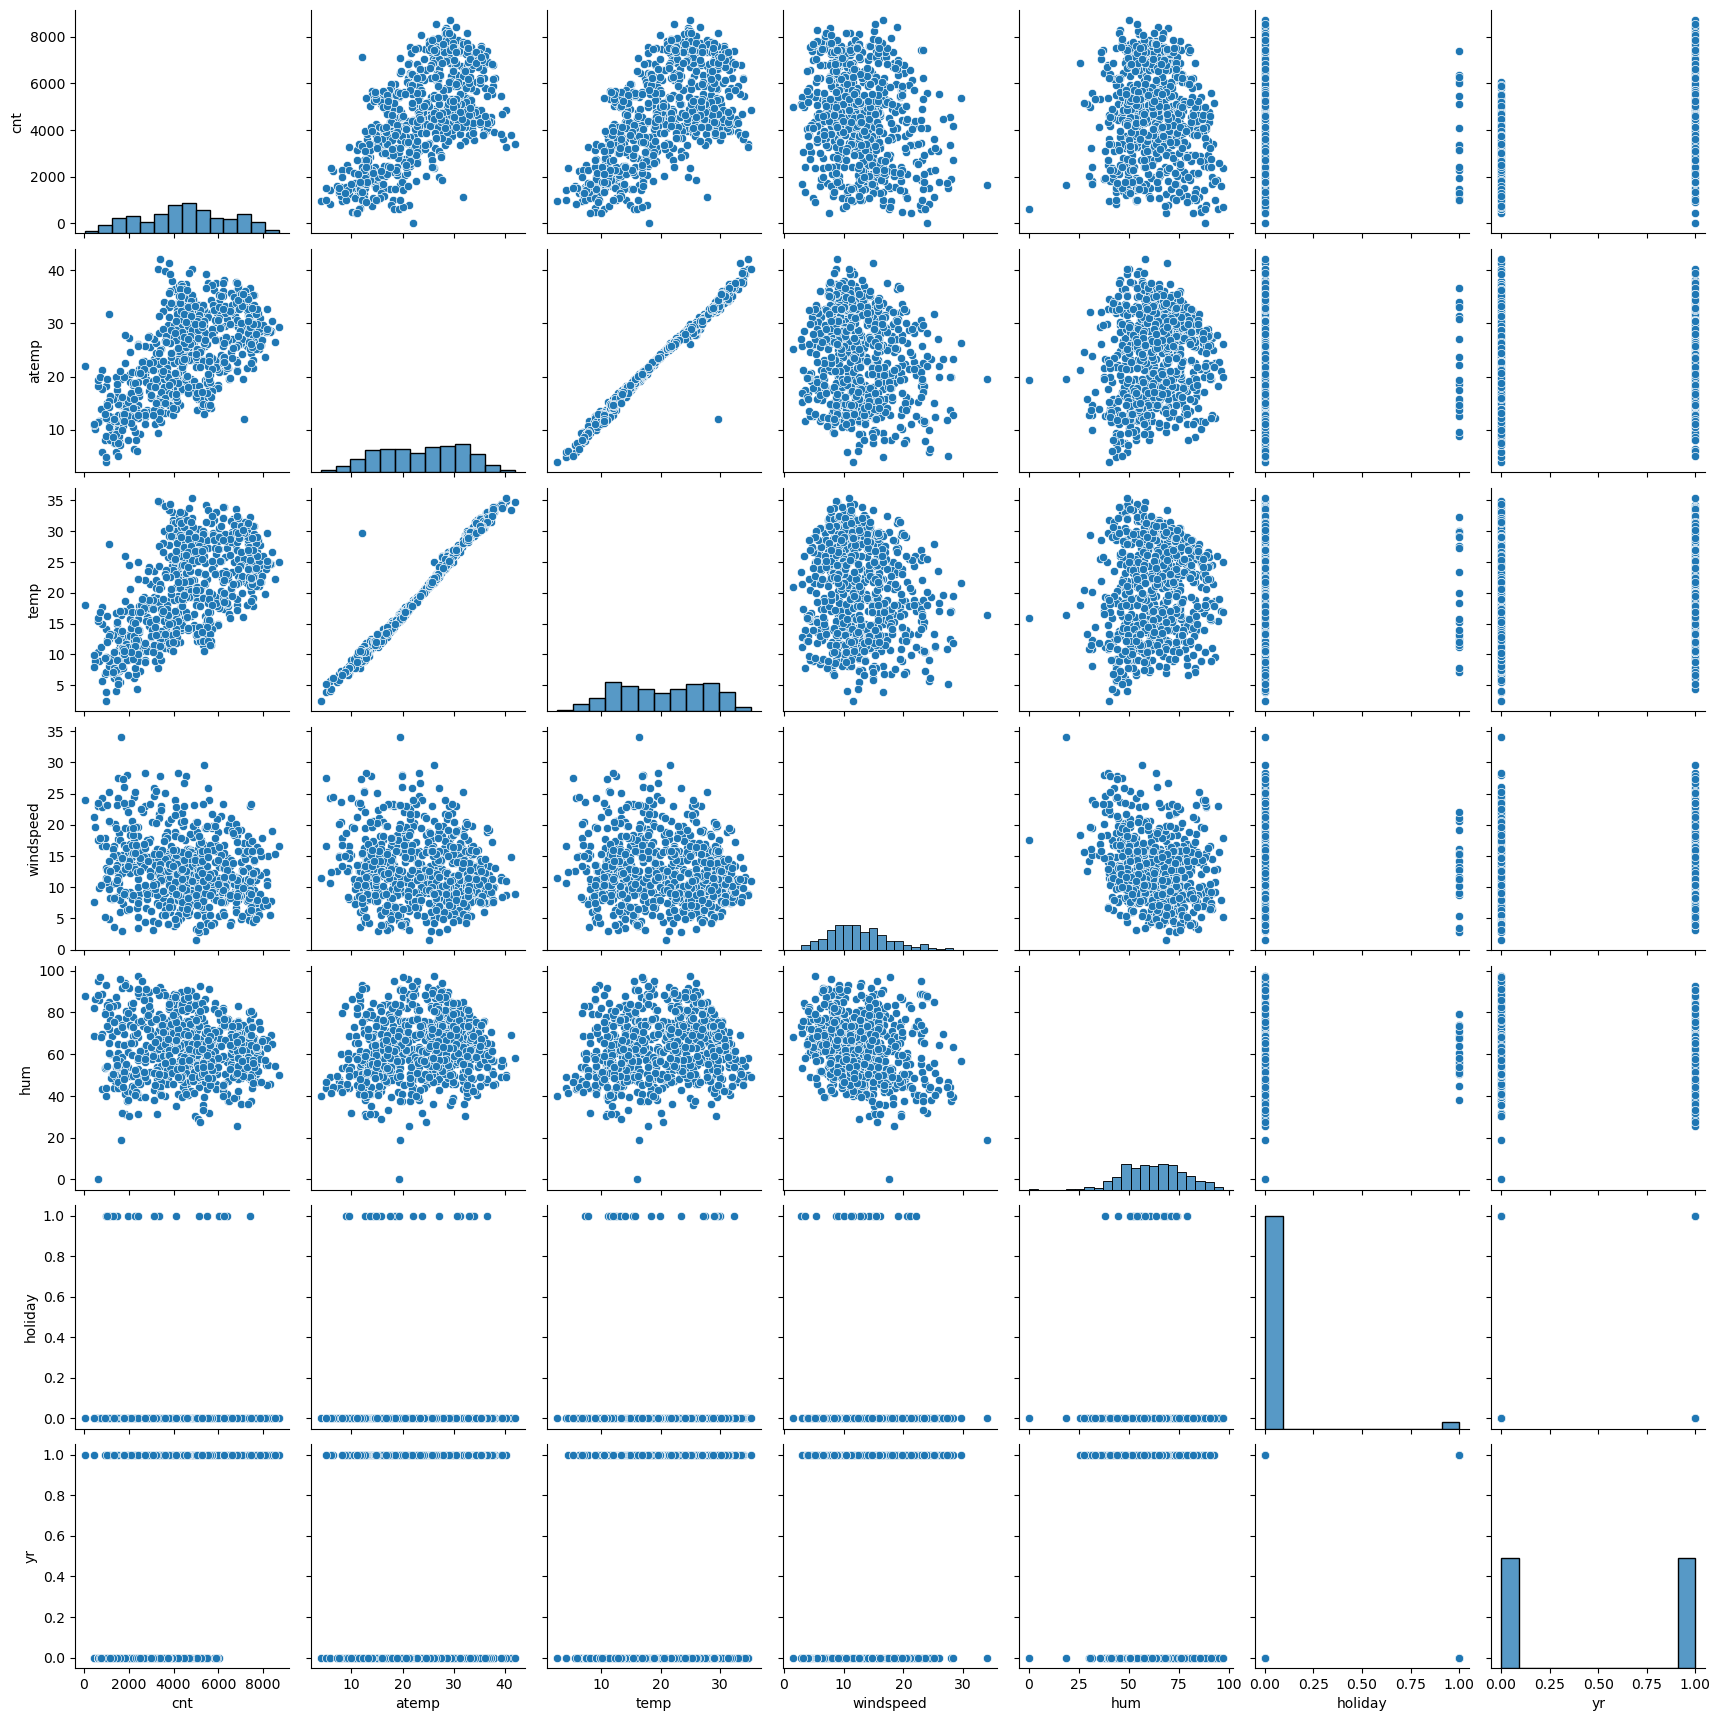

In [8]:
sb.pairplot(bbike_df[['cnt','atemp','temp','windspeed','hum','holiday','yr']])

In [9]:
bbike_df[['cnt','atemp','temp','windspeed','hum','holiday','yr']].corr()

,cnt,atemp,temp,windspeed,hum,holiday,yr
cnt,1.000000,0.630685,0.627044,-0.235132,-0.098543,-0.068764,0.569728
atemp,0.630685,1.000000,0.991696,-0.183876,0.141512,-0.032703,0.047215
temp,0.627044,0.991696,1.000000,-0.158186,0.128565,-0.028764,0.048789
windspeed,-0.235132,-0.183876,-0.158186,1.000000,-0.248506,0.006257,-0.011624
hum,-0.098543,0.141512,0.128565,-0.248506,1.000000,-0.015662,-0.112547
holiday,-0.068764,-0.032703,-0.028764,0.006257,-0.015662,1.000000,0.008195
yr,0.569728,0.047215,0.048789,-0.011624,-0.112547,0.008195,1.000000


In [10]:
def weathermeth(x):
    if x==1:
        return 'Clear Weather' #'Clear, Few clouds, Partly cloudy, Partly cloudy'
    elif x==2:
        return 'Misty weather'#'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist'
    elif x==3:
        return 'Light rain'#'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds'
    elif x==4:
        return 'heavy rain'#'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'
    
def seasonmeth(x):
    if x==1:
        return 'spring'
    elif x==2:
        return 'summer'
    elif x==3:
        return 'fall'
    elif x==4:
        return 'winter'
def monthmeth(x):
    if x==1:
        return 'Jan'
    elif x==2:
        return 'Feb'
    elif x==3:
        return 'Mar'
    elif x==4:
        return 'Apr'
    elif x==5:
        return 'May'
    elif x==6:
        return 'Jun'
    elif x==7:
        return 'Jul'
    elif x==8:
        return 'Aug'
    elif x==9:
        return 'Sep'
    elif x==10:
        return 'oct'
    elif x==11:
        return 'Nov'
    elif x==12:
        return 'Dec'
def weekdaymeth(x):
    if x==0:
        return 'Sun'
    elif x==1:
        return 'Mon'
    elif x==2:
        return 'Tue'
    elif x==3:
        return 'Wed'
    elif x==4:
        return 'Thu'
    elif x==5:
        return 'Fri'
    elif x==6:
        return 'Sat'

In [11]:
bbike_df['date']=bbike_df['dteday'].apply(lambda x: x.split('-')[0])
bbike_df['weathersit'] = bbike_df['weathersit'].apply(lambda x:weathermeth(x))
bbike_df['season'] = bbike_df['season'].apply(lambda x:seasonmeth(x))
bbike_df['mnth'] = bbike_df['mnth'].apply(lambda x:monthmeth(x))
bbike_df['weekday'] = bbike_df['weekday'].apply(lambda x:weekdaymeth(x))

In [12]:
bbike_df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,date
0,01-01-2018,spring,0,Jan,0,Sat,0,Misty weather,14.110847,18.18125,80.5833,10.749882,331,654,985,01
1,02-01-2018,spring,0,Jan,0,Sun,0,Misty weather,14.902598,17.68695,69.6087,16.652113,131,670,801,02
2,03-01-2018,spring,0,Jan,0,Mon,1,Clear Weather,8.050924,9.47025,43.7273,16.636703,120,1229,1349,03
3,04-01-2018,spring,0,Jan,0,Tue,1,Clear Weather,8.200000,10.60610,59.0435,10.739832,108,1454,1562,04
4,05-01-2018,spring,0,Jan,0,Wed,1,Clear Weather,9.305237,11.46350,43.6957,12.522300,82,1518,1600,05


#### Creating Dummies for season,weathersit, weekday, month

In [13]:
season_dummies = pd.get_dummies(bbike_df['season'], drop_first = True)
weather_dummies = pd.get_dummies(bbike_df['weathersit'], drop_first = True)
weekday_dummies = pd.get_dummies(bbike_df['weekday'], drop_first = True)
month_dummies = pd.get_dummies(bbike_df['mnth'], drop_first = True)

In [14]:
bbike_df = pd.concat([bbike_df,season_dummies,weather_dummies,weekday_dummies, month_dummies], axis = 1)

In [15]:
bbike_df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Sep,oct
0,01-01-2018,spring,0,Jan,0,Sat,0,Misty weather,14.110847,18.18125,...,0,0,1,0,0,0,0,0,0,0
1,02-01-2018,spring,0,Jan,0,Sun,0,Misty weather,14.902598,17.68695,...,0,0,1,0,0,0,0,0,0,0
2,03-01-2018,spring,0,Jan,0,Mon,1,Clear Weather,8.050924,9.47025,...,0,0,1,0,0,0,0,0,0,0
3,04-01-2018,spring,0,Jan,0,Tue,1,Clear Weather,8.200000,10.60610,...,0,0,1,0,0,0,0,0,0,0
4,05-01-2018,spring,0,Jan,0,Wed,1,Clear Weather,9.305237,11.46350,...,0,0,1,0,0,0,0,0,0,0


#### Univariate Analysis

##### creating bins for EDA

In [16]:
bbike_df['a_tempbins'] = pd.cut(bbike_df['atemp'], bins=10,precision =0)
bbike_df['hum_bins'] = pd.cut(bbike_df['hum'], bins=10,precision =0)
bbike_df['wind_bins'] = pd.cut(bbike_df['windspeed'], bins=15,precision =0)

<Axes: xlabel='season', ylabel='count'>

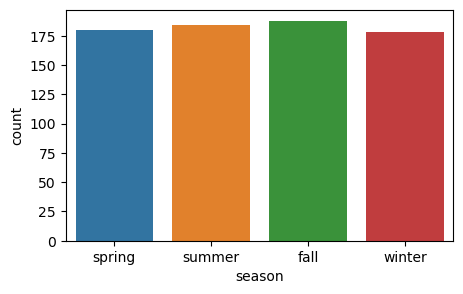

In [17]:
pl.figure(figsize=(5, 3))
sb.countplot(x='season',data=bbike_df)

<Axes: xlabel='count', ylabel='weathersit'>

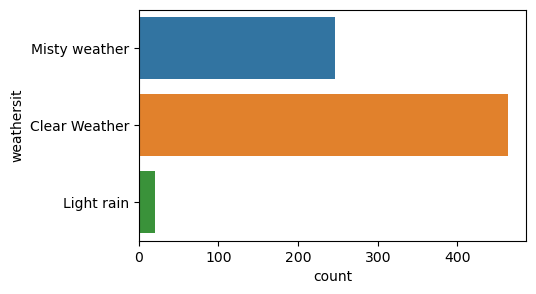

In [18]:
pl.figure(figsize=(5, 3))
sb.countplot(y='weathersit',data=bbike_df)

<Axes: xlabel='holiday', ylabel='count'>

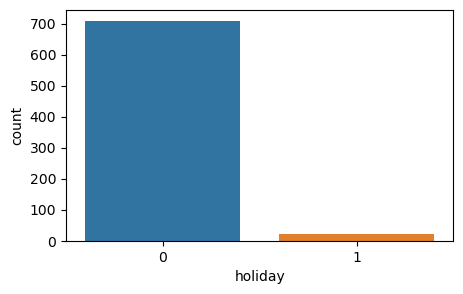

In [19]:
pl.figure(figsize=(5, 3))
sb.countplot(x='holiday',data=bbike_df)

<Axes: xlabel='workingday', ylabel='count'>

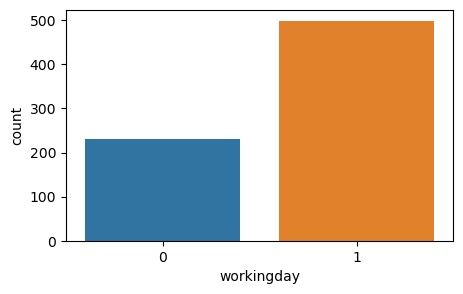

In [20]:
pl.figure(figsize=(5, 3))
sb.countplot(x='workingday',data=bbike_df)

In [21]:
#Bivariate Analysis

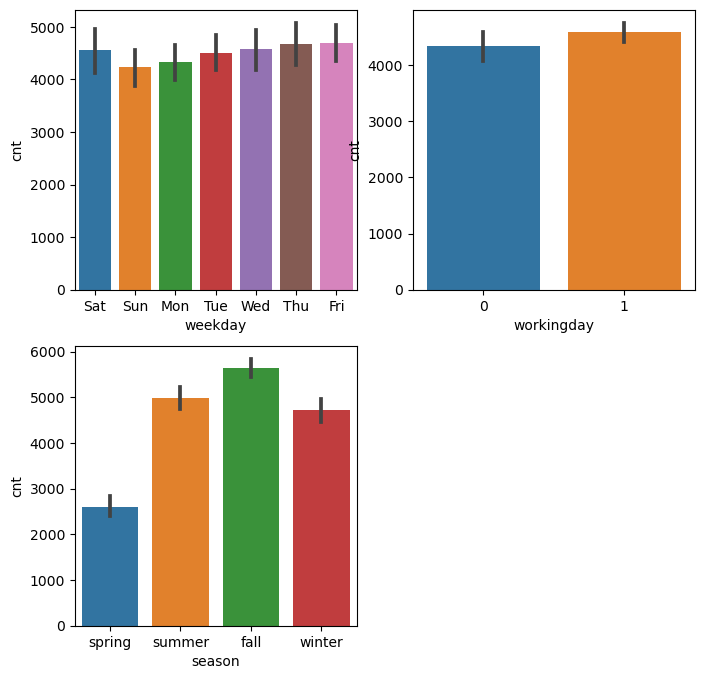

In [22]:
pl.figure(figsize=(8, 8))
pl.subplot(2,2,1)
sb.barplot(data = bbike_df,x='weekday', y='cnt')
pl.subplot(2,2,2)
sb.barplot(data = bbike_df,x='workingday', y='cnt')
pl.subplot(2,2,3)
sb.barplot(data = bbike_df,x='season', y='cnt')
pl.show()

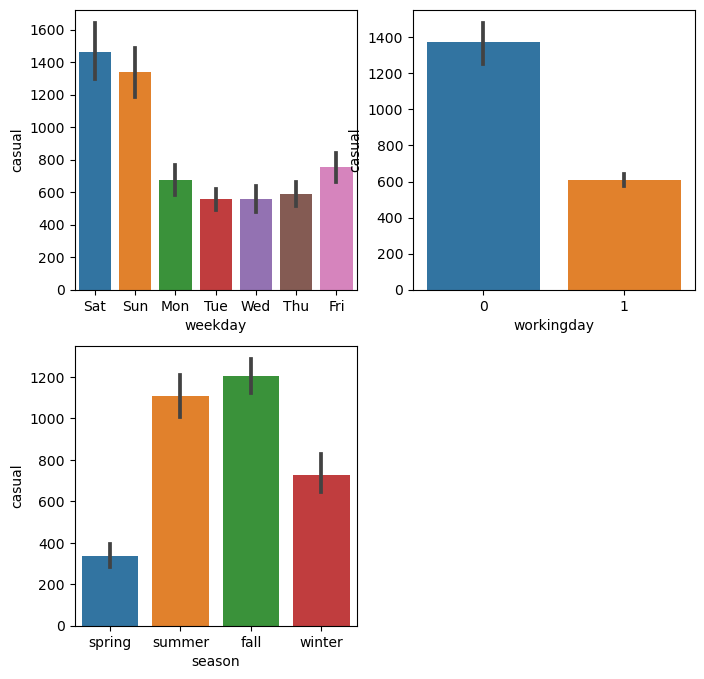

In [23]:
pl.figure(figsize=(8, 8))
pl.subplot(2,2,1)
sb.barplot(data = bbike_df,x='weekday', y='casual')
pl.subplot(2,2,2)
sb.barplot(data = bbike_df,x='workingday', y='casual')
pl.subplot(2,2,3)
sb.barplot(data = bbike_df,x='season', y='casual')
pl.show()

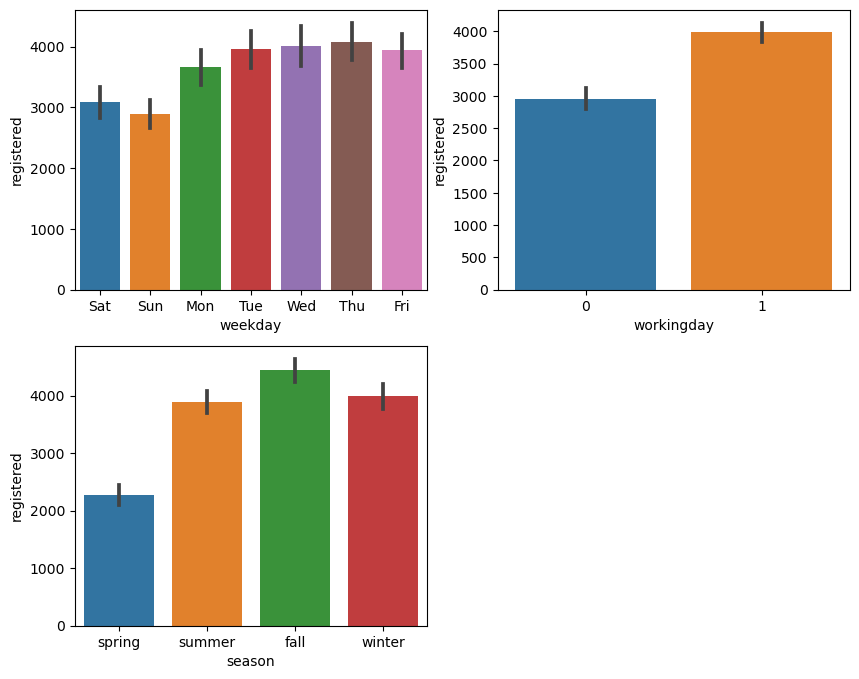

In [24]:
pl.figure(figsize=(10, 8))
pl.subplot(2,2,1)
sb.barplot(data = bbike_df,x='weekday', y='registered')
pl.subplot(2,2,2)
sb.barplot(data = bbike_df,x='workingday', y='registered')
pl.subplot(2,2,3)
sb.barplot(data = bbike_df,x='season', y='registered')
pl.show()

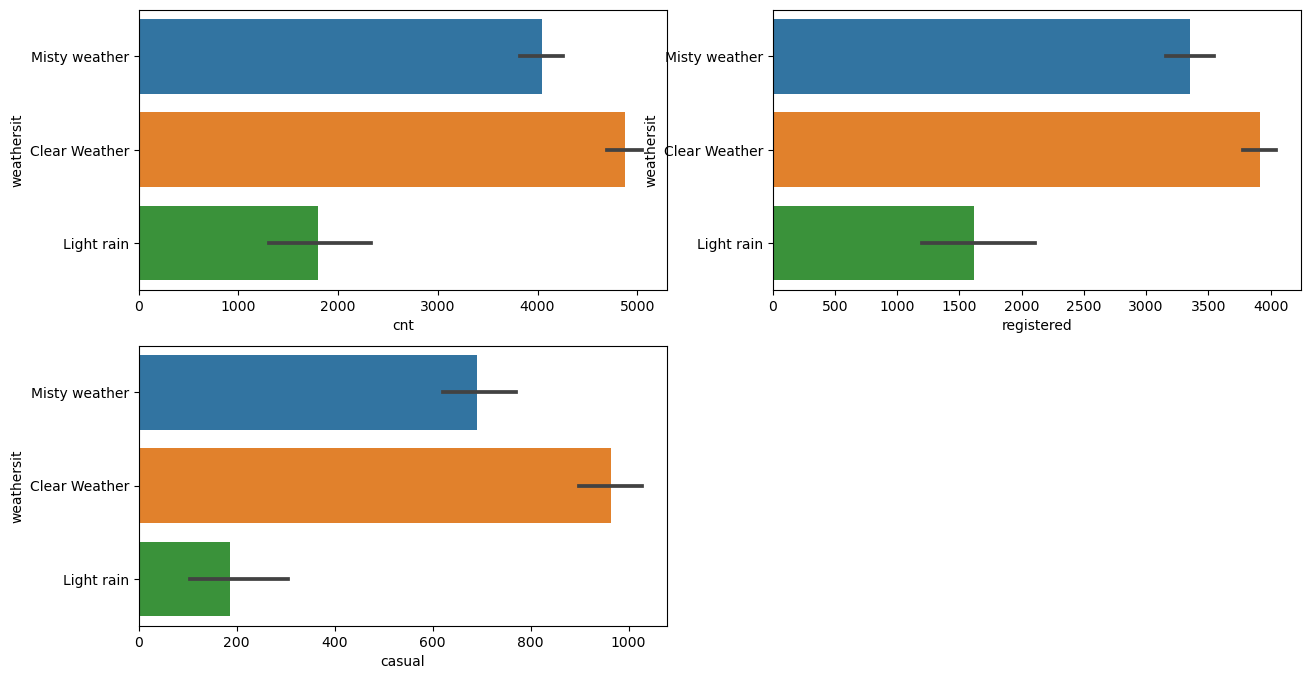

In [25]:
pl.figure(figsize=(15, 8))
pl.subplot(2,2,1)
sb.barplot(data = bbike_df,x='cnt', y='weathersit')
pl.subplot(2,2,2)
sb.barplot(data = bbike_df,x='registered', y='weathersit')
pl.subplot(2,2,3)
sb.barplot(data = bbike_df,x='casual', y='weathersit')
pl.show()


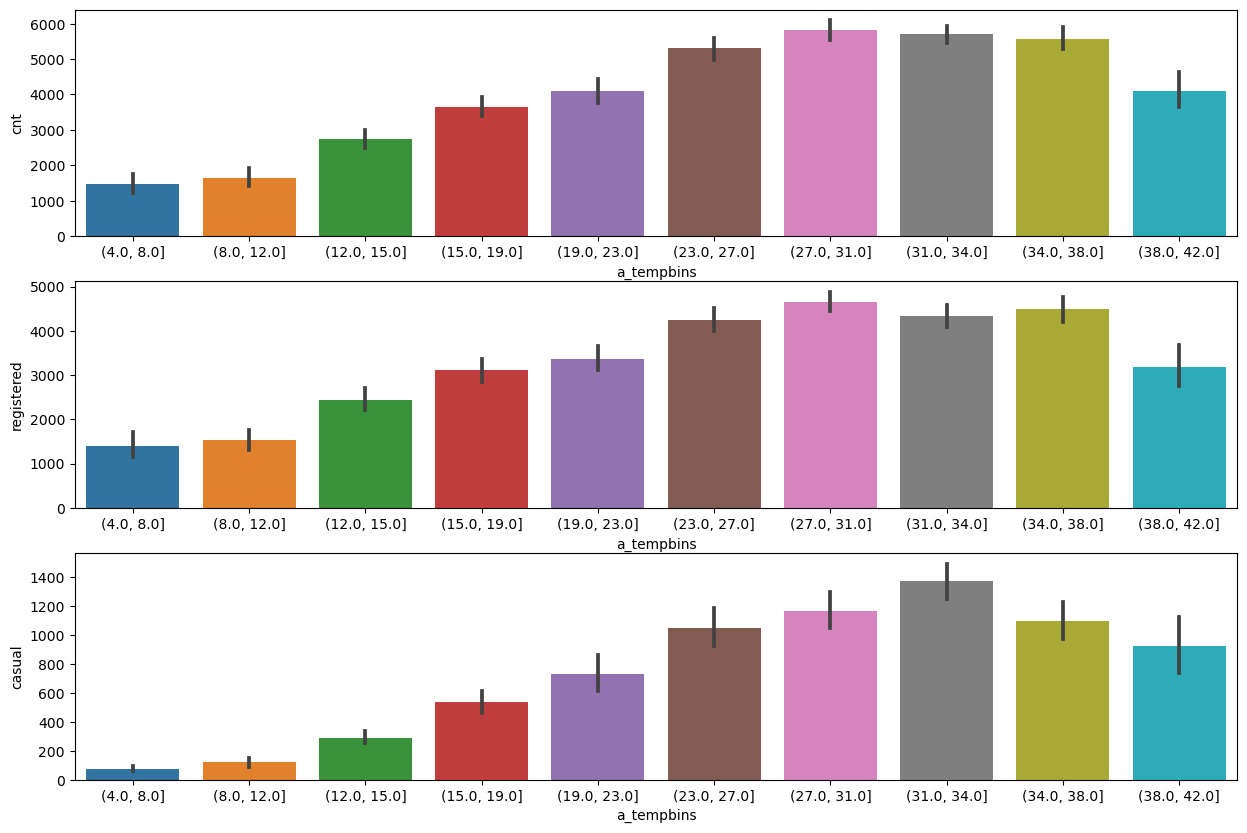

In [26]:
pl.figure(figsize=(15, 10))
pl.subplot(3,1,1)
sb.barplot(data = bbike_df,x='a_tempbins', y='cnt')
pl.subplot(3,1,2)
sb.barplot(data = bbike_df,x='a_tempbins', y='registered')
pl.subplot(3,1,3)
sb.barplot(data = bbike_df,x='a_tempbins', y='casual')
pl.show()

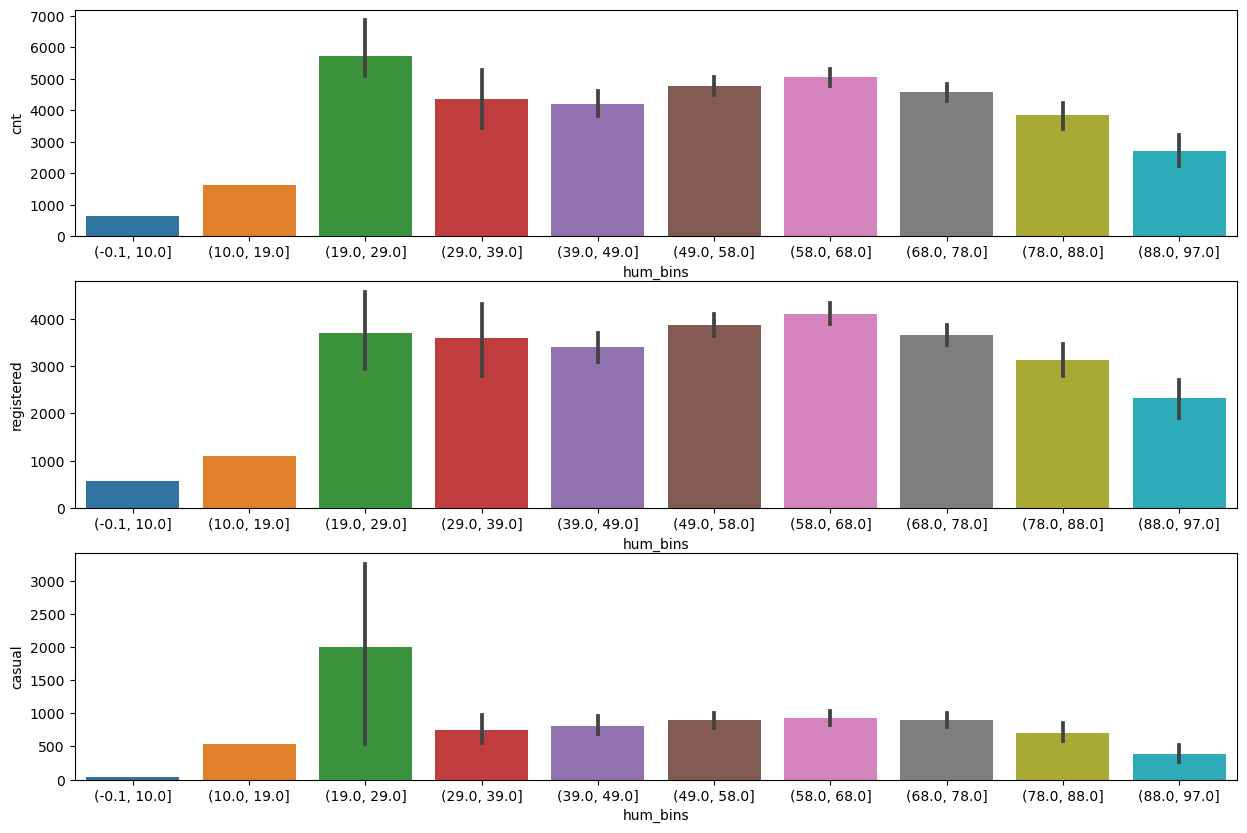

In [27]:
pl.figure(figsize=(15, 10))
pl.subplot(3,1,1)
sb.barplot(data = bbike_df,x='hum_bins', y='cnt')
pl.subplot(3,1,2)
sb.barplot(data = bbike_df,x='hum_bins', y='registered')
pl.subplot(3,1,3)
sb.barplot(data = bbike_df,x='hum_bins', y='casual')
pl.show()

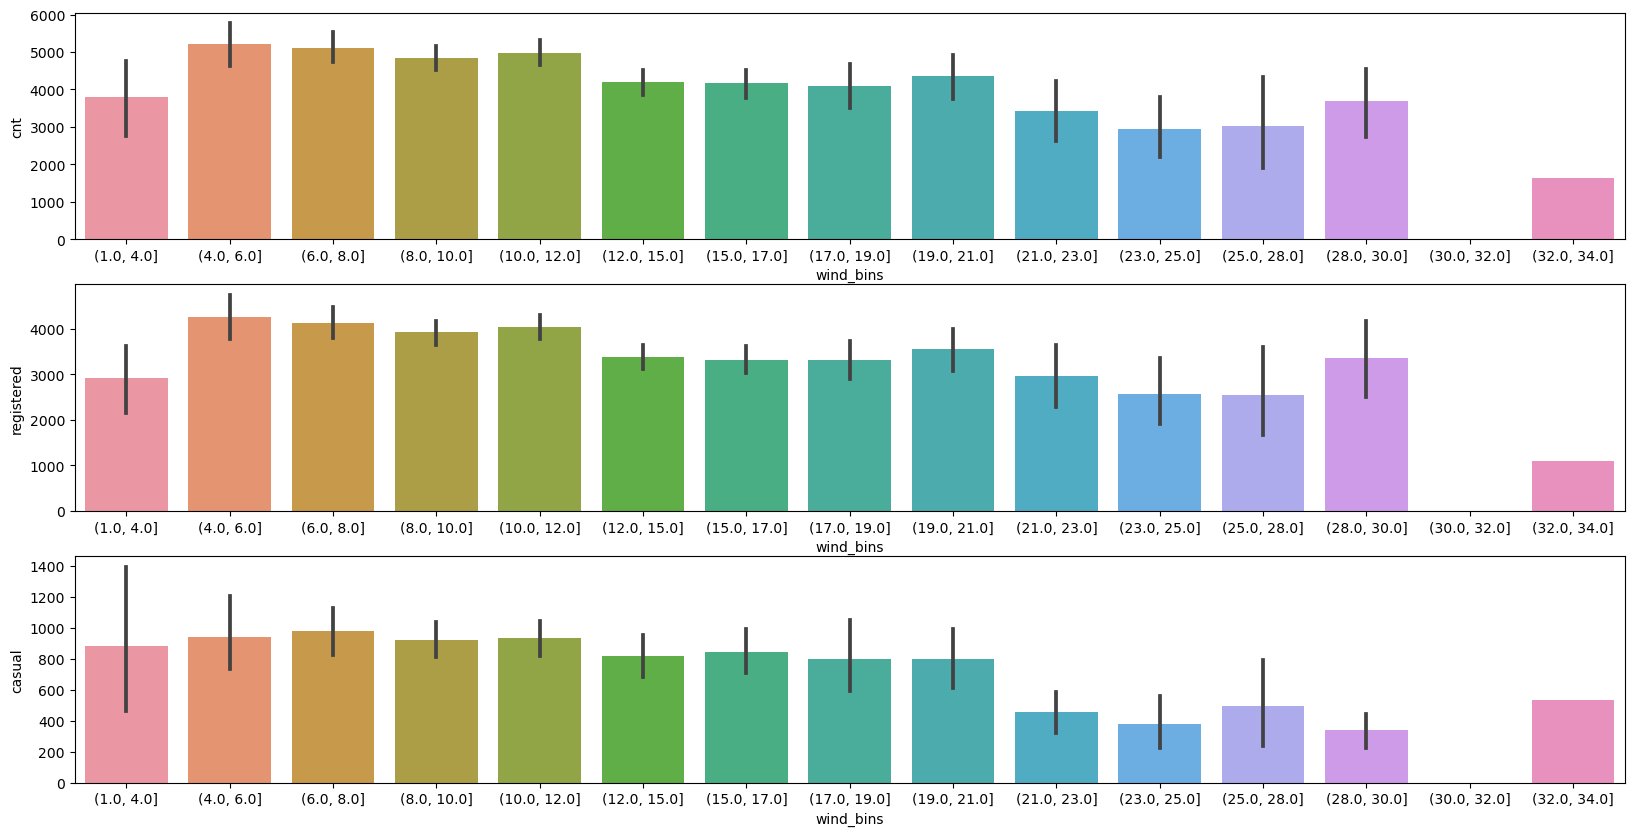

In [28]:
pl.figure(figsize=(20, 10))
pl.subplot(3,1,1)
sb.barplot(data = bbike_df,x='wind_bins', y='cnt')
pl.subplot(3,1,2)
sb.barplot(data = bbike_df,x='wind_bins', y='registered')
pl.subplot(3,1,3)
sb.barplot(data = bbike_df,x='wind_bins', y='casual')
pl.show()

#### Observations
- The registered bike count is almost equally distributed across all temperatures and humidity. 
- The Casual bike registrations are skewed, meaning people are favouring certain temparature and humidity.
-  On rainy weather days the bike usage count is coming down alot compared to clear days and misty days. So we can be more profitted if we can scale down the bike count in rainy season.
- On weekdays or on holidays the Casual bike count is more. On working days the registered bike count is more.
- There is no much change in bike usage across seasons(Spring, Summer, Fall, Winter).

### Multivariate Linear Regression

##### Cleaning the data

In [29]:
bbike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 41 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   dteday         730 non-null    object  
 1   season         730 non-null    object  
 2   yr             730 non-null    int64   
 3   mnth           730 non-null    object  
 4   holiday        730 non-null    int64   
 5   weekday        730 non-null    object  
 6   workingday     730 non-null    int64   
 7   weathersit     730 non-null    object  
 8   temp           730 non-null    float64 
 9   atemp          730 non-null    float64 
 10  hum            730 non-null    float64 
 11  windspeed      730 non-null    float64 
 12  casual         730 non-null    int64   
 13  registered     730 non-null    int64   
 14  cnt            730 non-null    int64   
 15  date           730 non-null    object  
 16  spring         730 non-null    uint8   
 17  summer         730 non-null    uint

#### There are no empty values in any of the columns.

- Dropping columns which the dummies are based off of
- Columns 'Casual' and 'registered' are linerly in relation with cnt, so dropping them.
- Bin columns which are created for EDA are also being dropped.


In [30]:
bbike_df[['temp','atemp']].corr()

,temp,atemp
temp,1.000000,0.991696
atemp,0.991696,1.000000


##### Columns 'temp' and 'atemp' are 99% correlated so dropping column 'temp', as column 'atemp' seems to be more usefull for business.

In [31]:
col_drop = ['casual','registered','temp','season','weathersit','dteday','weekday','mnth']
bin_cols = ['a_tempbins','hum_bins','wind_bins']

bbike_df.drop(bin_cols+col_drop, axis = 1, inplace = True)

In [32]:
bbike_df.head()

,yr,holiday,workingday,atemp,hum,windspeed,cnt,date,spring,summer,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Sep,oct
0,0,0,0,18.18125,80.5833,10.749882,985,01,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,17.68695,69.6087,16.652113,801,02,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,1,9.47025,43.7273,16.636703,1349,03,1,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,10.60610,59.0435,10.739832,1562,04,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,11.46350,43.6957,12.522300,1600,05,1,0,...,0,0,1,0,0,0,0,0,0,0


In [33]:
df_train, df_test = train_test_split(bbike_df, train_size = 0.7, test_size = 0.3, random_state = 100)

##### Splitting the data set into 70:30

In [34]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 653 to 79
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   yr             510 non-null    int64  
 1   holiday        510 non-null    int64  
 2   workingday     510 non-null    int64  
 3   atemp          510 non-null    float64
 4   hum            510 non-null    float64
 5   windspeed      510 non-null    float64
 6   cnt            510 non-null    int64  
 7   date           510 non-null    object 
 8   spring         510 non-null    uint8  
 9   summer         510 non-null    uint8  
 10  winter         510 non-null    uint8  
 11  Light rain     510 non-null    uint8  
 12  Misty weather  510 non-null    uint8  
 13  Mon            510 non-null    uint8  
 14  Sat            510 non-null    uint8  
 15  Sun            510 non-null    uint8  
 16  Thu            510 non-null    uint8  
 17  Tue            510 non-null    uint8  
 18  Wed      

In [35]:
scaler = MinMaxScaler()

In [36]:
num_vars = ['atemp', 'hum', 'windspeed','cnt',]
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

,yr,holiday,workingday,atemp,hum,windspeed,cnt,date,spring,summer,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Sep,oct
653,1,0,1,0.501133,0.575354,0.300794,0.864243,16,0,0,...,0,0,0,0,0,0,0,0,0,1
576,1,0,1,0.766351,0.725633,0.264686,0.827658,31,0,0,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,0.438975,0.640189,0.255342,0.465255,03,1,0,...,0,0,0,0,0,1,0,0,0,0
728,1,0,0,0.200348,0.498067,0.663106,0.204096,30,1,0,...,1,0,0,0,0,0,0,0,0,0
482,1,0,0,0.391735,0.504508,0.188475,0.482973,28,0,1,...,0,0,0,0,0,0,0,0,0,0


In [37]:
y_train = df_train.pop('cnt')
X_train = df_train

In [38]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

##### We have 30 columns, as this is the hybrid approach, starting with 15 columns.

In [39]:
rfe = RFE(lm,n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

In [40]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('date', False, 15),
 ('spring', True, 1),
 ('summer', False, 6),
 ('winter', True, 1),
 ('Light rain', True, 1),
 ('Misty weather', True, 1),
 ('Mon', False, 9),
 ('Sat', True, 1),
 ('Sun', True, 1),
 ('Thu', False, 11),
 ('Tue', False, 10),
 ('Wed', False, 12),
 ('Aug', False, 7),
 ('Dec', False, 3),
 ('Feb', False, 4),
 ('Jan', True, 1),
 ('Jul', True, 1),
 ('Jun', False, 8),
 ('Mar', False, 14),
 ('May', False, 5),
 ('Nov', False, 2),
 ('Sep', True, 1),
 ('oct', False, 13)]

In [41]:
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'spring',
       'winter', 'Light rain', 'Misty weather', 'Sat', 'Sun', 'Jan', 'Jul',
       'Sep'],
      dtype='object')

In [42]:
X_train_model_1 = X_train[col]
X_train_model_1 = sm.add_constant(X_train_model_1)
lm = sm.OLS(y_train,X_train_model_1).fit() 
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     189.6
Date:                Wed, 16 Aug 2023   Prob (F-statistic):          1.66e-188
Time:                        18:58:50   Log-Likelihood:                 510.32
No. Observations:                 510   AIC:                            -990.6
Df Residuals:                     495   BIC:                            -927.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2535      0.026      9.914

#### 84% r2 is a good result and F-statistic with 189 is good reliable model. Now lets see how the model changes, after adding the 16th most usefull column

In [43]:
col=col.append(pd.Index(['Nov']))
col

Index(['yr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'spring',
       'winter', 'Light rain', 'Misty weather', 'Sat', 'Sun', 'Jan', 'Jul',
       'Sep', 'Nov'],
      dtype='object')

In [44]:
X_train_model_2=X_train[col]
X_train_model_2 = sm.add_constant(X_train_model_2)
lm_2 = sm.OLS(y_train,X_train_model_2).fit() 
print(lm_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     178.0
Date:                Wed, 16 Aug 2023   Prob (F-statistic):          4.53e-188
Time:                        18:58:51   Log-Likelihood:                 512.02
No. Observations:                 510   AIC:                            -992.0
Df Residuals:                     494   BIC:                            -924.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2593      0.026     10.086

#### There has not been much increase in r2, but the F-Statistic decreased by more than10 points so not considering any of the columns below column Nov

#### Now removing the column 'holiday' as it has got very high p value. 

In [45]:
#dropping volumn holiday and Nov
col=col.drop(['holiday','Nov'])
col

Index(['yr', 'workingday', 'atemp', 'hum', 'windspeed', 'spring', 'winter',
       'Light rain', 'Misty weather', 'Sat', 'Sun', 'Jan', 'Jul', 'Sep'],
      dtype='object')

In [46]:
X_train_model_3 = X_train[col]
X_train_model_3 = sm.add_constant(X_train_model_3)
lm_3 = sm.OLS(y_train,X_train_model_3).fit() 
print(lm_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     189.6
Date:                Wed, 16 Aug 2023   Prob (F-statistic):          1.66e-188
Time:                        18:58:53   Log-Likelihood:                 510.32
No. Observations:                 510   AIC:                            -990.6
Df Residuals:                     495   BIC:                            -927.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2510      0.040      6.252

#### There is no significant drop in r2 even after dropping column 'holiday' 
#### As there are no column with high p-values lets look at Variance Inflation Factor and see if we can improve the model

In [47]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
X = X_train_model_3
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,100.81
2,workingday,9.07
10,Sat,6.06
11,Sun,5.74
3,atemp,3.11
6,spring,2.66
4,hum,1.91
7,winter,1.75
9,Misty weather,1.57
12,Jan,1.56


#### Column 'working day' has considerably high VIF lets see if the model improves on dropping.

In [48]:
col=col.drop(['workingday'])
col

Index(['yr', 'atemp', 'hum', 'windspeed', 'spring', 'winter', 'Light rain',
       'Misty weather', 'Sat', 'Sun', 'Jan', 'Jul', 'Sep'],
      dtype='object')

In [49]:
X_train_model_4 = X_train[col]
X_train_model_4 = sm.add_constant(X_train_model_4)
lm_4 = sm.OLS(y_train,X_train_model_4).fit() 
print(lm_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     197.5
Date:                Wed, 16 Aug 2023   Prob (F-statistic):          1.65e-186
Time:                        18:58:55   Log-Likelihood:                 502.80
No. Observations:                 510   AIC:                            -977.6
Df Residuals:                     496   BIC:                            -918.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3474      0.032     10.921

#### dropping column Sat as its having increased p-value

In [50]:
col=col.drop(['Sat'])
col

Index(['yr', 'atemp', 'hum', 'windspeed', 'spring', 'winter', 'Light rain',
       'Misty weather', 'Sun', 'Jan', 'Jul', 'Sep'],
      dtype='object')

In [51]:
X_train_model_5 = X_train[col]
X_train_model_5 = sm.add_constant(X_train_model_5)
lm_5 = sm.OLS(y_train,X_train_model_5).fit() 
print(lm_5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     213.6
Date:                Wed, 16 Aug 2023   Prob (F-statistic):          2.28e-187
Time:                        18:58:56   Log-Likelihood:                 502.05
No. Observations:                 510   AIC:                            -978.1
Df Residuals:                     497   BIC:                            -923.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3508      0.032     11.067

In [52]:
vif = pd.DataFrame()
X = X_train_model_5
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,61.08
2,atemp,3.11
5,spring,2.66
3,hum,1.90
6,winter,1.74
8,Misty weather,1.57
10,Jan,1.56
11,Jul,1.30
7,Light rain,1.25
4,windspeed,1.20


#### Now the VIF is showing there is linear dependance among the feature columns.
#### The r2 is considerably high, now lets see the r2 for the test set by using the 5th model.

#### The final model is cnt = 0.35 + 0.25*yr + 0.48* atemp - 0.14*hum - 0.16* windspeed - 0.10*spring + 0.04*winter           - 0.24*Light rain - 0.05 * misty weather -0.04 * Sun - 0.04*Jan - 0.07*Jul + 0.06*Sep

In [53]:
y_train_res = lm_5.predict(X_train_model_5)

C:\Users\chait\AppData\Local\Temp\ipykernel_20440\2213587363.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot((y_train - y_train_res), bins = 20)


Text(0.5, 0, 'Errors')

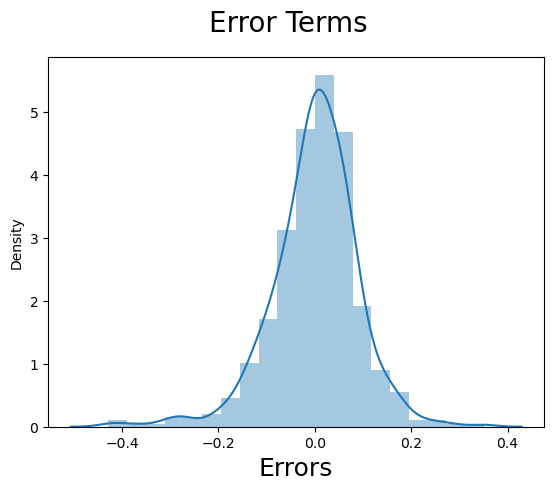

In [54]:
fig = pl.figure()
sb.distplot((y_train - y_train_res), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)
pl.xlabel('Errors', fontsize = 18)   

#### The errors are normally distributed.

In [55]:
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [56]:
y_test = df_test.pop('cnt')
X_test = df_test

In [57]:
X_test_pred = X_test[col]

In [58]:
X_test_pred

,yr,atemp,hum,windspeed,spring,winter,Light rain,Misty weather,Sun,Jan,Jul,Sep
184,0,0.769660,0.657364,0.084219,0,0,0,1,0,0,1,0
535,1,0.842587,0.610133,0.153728,0,0,0,0,0,0,0,0
299,0,0.496145,0.837699,0.334206,0,1,0,1,0,0,0,0
221,0,0.795343,0.437098,0.339570,0,0,0,0,0,0,0,0
152,0,0.741471,0.314298,0.537414,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
400,1,0.243430,0.708888,0.287411,1,0,0,1,1,0,0,0
702,1,0.511907,0.756118,0.283397,0,1,0,0,0,0,0,0
127,0,0.577380,0.650923,0.069510,0,0,0,0,1,0,0,0
640,1,0.682653,0.817947,0.052115,0,1,0,1,0,0,0,0


In [59]:
X_test_pred = sm.add_constant(X_test_pred)

In [60]:
X_test_pred.describe()

,const,yr,atemp,hum,windspeed,spring,winter,Light rain,Misty weather,Sun,Jan,Jul,Sep
count,219.0,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,1.0,0.479452,0.532991,0.638508,0.313350,0.255708,0.232877,0.027397,0.319635,0.146119,0.077626,0.105023,0.086758
std,0.0,0.500722,0.217888,0.148974,0.159947,0.437258,0.423633,0.163612,0.467403,0.354034,0.268194,0.307285,0.282125
min,1.0,0.000000,0.025950,0.261915,-0.042808,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.344751,0.527265,0.198517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,0.000000,0.549198,0.627737,0.299459,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,1.000000,0.714132,0.743928,0.403048,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.0,1.000000,0.980934,1.002146,0.807474,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### We can see the scaling is done according to the train test and the same scaling is being used for test set.

In [61]:
X_test_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 184 to 72
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   const          219 non-null    float64
 1   yr             219 non-null    int64  
 2   atemp          219 non-null    float64
 3   hum            219 non-null    float64
 4   windspeed      219 non-null    float64
 5   spring         219 non-null    uint8  
 6   winter         219 non-null    uint8  
 7   Light rain     219 non-null    uint8  
 8   Misty weather  219 non-null    uint8  
 9   Sun            219 non-null    uint8  
 10  Jan            219 non-null    uint8  
 11  Jul            219 non-null    uint8  
 12  Sep            219 non-null    uint8  
dtypes: float64(4), int64(1), uint8(8)
memory usage: 12.0 KB


In [62]:
y_test_pred = lm_5.predict(X_test_pred)

In [63]:
r2_score(y_true = y_test,y_pred = y_test_pred)

0.8181881171729286

### R2 of 82% for the test set and 84% for train set. By this we can conclude that this model is reliable and can be used in predicting the Bike usage.

#### Now lets see how the y_test and y_test predicted from model scatter.

Text(0, 0.5, 'y_pred')

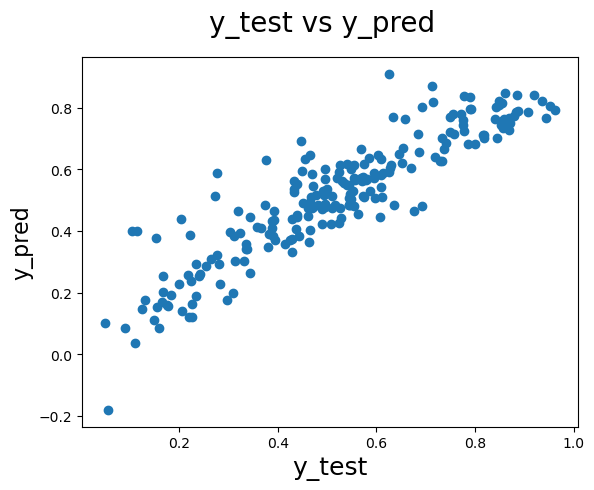

In [64]:
fig = pl.figure()
pl.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)          
pl.xlabel('y_test', fontsize = 18)                       
pl.ylabel('y_pred', fontsize = 16)   

### We can see they are almost linearly related.